In [ ]:
!pip install d2l==0.16

In [4]:
import math
import torch
from torch import nn
from d2l import torch as d2l

我们可以在下面的 masked_softmax 函数中实现这样的 遮蔽 softmax 操作（masked softmax operation），其中任何超出有效长度的位置都被遮蔽并置为0

In [7]:
def masked_softmax(X,valid_lens):
  """通过在最后一个轴上遮蔽元素来执行softmax操作"""
  if valid_lens is None:
    return nn.functional.softmax(X,dim=-1)
  else:
    shape=X.shape
    if valid_lens.dim()==1:
      valid_lens=torch.repeat_interleave(valid_lens,shape[1])
    else:
      valid_lens=valid_lens.reshape(-1)
    #在最后的轴上，被遮蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
    X=d2l.sequence_mask(X.reshape(-1,shape[-1]),valid_lens,value=-1e6)
    return nn.functional.softmax(X.reshape(shape),dim=-1)

为了演示此函数是如何工作的，考虑由两个  2×4  矩阵表示的样本，这两个样本的有效长度分别为  2  和  3 。经过遮蔽 softmax 操作，超出有效长度的值都被遮蔽为0。

In [8]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5420, 0.4580, 0.0000, 0.0000],
         [0.5428, 0.4572, 0.0000, 0.0000]],

        [[0.2290, 0.2533, 0.5176, 0.0000],
         [0.3941, 0.3467, 0.2592, 0.0000]]])

同样，我们也可以使用二维张量为矩阵样本中的每一行指定有效长度。

In [9]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4189, 0.1988, 0.3823, 0.0000]],

        [[0.5307, 0.4693, 0.0000, 0.0000],
         [0.2154, 0.3236, 0.2555, 0.2055]]])

加性注意力

In [12]:
class AdditiveAttention(nn.Module):
  def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
    super(AdditiveAttention,self).__init__(**kwargs)
    self.W_k=nn.Linear(key_size,num_hiddens,bias=False)
    self.W_q=nn.Linear(query_size,num_hiddens,bias=False)
    self.w_v=nn.Linear(num_hiddens,1,bias=False)
    self.dropout=nn.Dropout(dropout)
  
  def forward(self,queries,keys,values,valid_lens):
    queries,keys=self.W_q(queries),self.W_k(keys)
    # 在维度扩展后，
    # `queries` 的形状：(`batch_size`, 查询的个数, 1, `num_hidden`)
    # `key` 的形状：(`batch_size`, 1, “键－值”对的个数, `num_hiddens`)
    # 使用广播方式进行求和
    features=queries.unsqueeze(2)+keys.unsqueeze(1)
    features=torch.tanh(features)
    # `self.w_v` 仅有一个输出，因此从形状中移除最后那个维度。
    # `scores` 的形状：(`batch_size`, 查询的个数, “键-值”对的个数)
    scores=self.w_v(features).squeeze(-1)
    self.attention_weights=masked_softmax(scores,valid_lens)
    # `values` 的形状：(`batch_size`, “键－值”对的个数, 值的维度)
    return torch.bmm(self.dropout(self.attention_weights),values)

让我们用一个小例子来演示上面的AdditiveAttention类，其中查询、键和值的形状为（批量大小、步数或词元序列长度、特征大小），实际输出为  (2,1,20) 、 (2,10,2)  和  (2,10,4) 。注意力汇聚输出的形状为（批量大小、查询的步数、值的维度）。




In [13]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# `values` 的小批量数据集中，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，所以注意力权重是均匀的，由指定的有效长度决定。

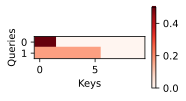

In [14]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

使用点积可以得到计算效率更高的评分函数。但是点积操作要求查询和键具有相同的长度  d 。

In [15]:
class DotProductAttention(nn.Module):
  def __init__(self,dropout,**kwargs):
    super(DotProductAttention,self).__init__(**kwargs)
    self.dropout=nn.Dropout(dropout)
    # `queries` 的形状：(`batch_size`, 查询的个数, `d`)
    # `keys` 的形状：(`batch_size`, “键－值”对的个数, `d`)
    # `values` 的形状：(`batch_size`, “键－值”对的个数, 值的维度)
    # `valid_lens` 的形状: (`batch_size`,) 或者 (`batch_size`, 查询的个数)
  def forward(self,queries,keys,values,valid_lens=None):
    d=queries.shape[-1]
    # 设置 `transpose_b=True` 为了交换 `keys` 的最后两个维度
    scores=torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
    self.attention_weights=masked_softmax(scores,valid_lens)
    return torch.bmm(self.dropout(self.attention_weights),values)


为了演示上述的DotProductAttention类，我们使用了与先前加性注意力例子中相同的键、值和有效长度。对于点积操作，令查询的特征维度与键的特征维度大小相同。

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素，而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。

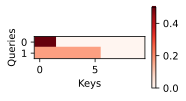

In [17]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')